The bones of this ray tracing stuff come from [here](https://medium.com/swlh/ray-tracing-from-scratch-in-python-41670e6a96f9)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial
import imageio
from datetime import datetime


plt.rcParams['figure.figsize'] = (20, 8)

AU_TO_M = 1.496e11  # Distance to Sun, in meters

In [14]:
def gif_outputs(all_images, name=None):
    name = (
        name if name else
        str(datetime.now()).replace(" ", "_").replace(":", "h")[:16]
    )
    dpath = f"./plots/{name}/"
    if not os.path.exists(dpath):
        print("Making", dpath)
        os.makedirs(dpath)

    filenames = []
    for i, image in tqdm(enumerate(all_images), total=len(all_images)):
        fname = f"{dpath}{round(i/n * 100)}_pct.png"
        filenames.append(fname)

        plt.imshow(image)
        plt.savefig(fname)
    
    pngs = [imageio.imread(fname) for fname in tqdm(filenames)]
    imageio.mimsave(f'{dpath}total.gif', pngs)
    
    plt.clf()
    r_sum = [np.sum(im[:, :, 0]) for im in all_images]
    g_sum = [np.sum(im[:, :, 1]) for im in all_images]
    b_sum = [np.sum(im[:, :, 2]) for im in all_images]

    plt.plot(np.linspace(0, 12, n), r_sum, "-or")
    plt.plot(np.linspace(0, 12, n), b_sum, "-ob")
    plt.plot(np.linspace(0, 12, n), g_sum, "-og")

    plt.xlabel("Hour", weight="bold", fontsize=14)
    plt.ylabel("Intensity?", weight="bold", fontsize=14)
    plt.savefig(f"{dpath}intensity_timeseries.png")

In [3]:
def normalize(vector):
    return vector / np.linalg.norm(vector)

def reflected(vector, axis):
    return vector - 2 * np.dot(vector, axis) * axis

def sphere_intersect(center, radius, ray_origin, ray_direction):
    b = 2 * np.dot(ray_direction, ray_origin - center)
    c = np.linalg.norm(ray_origin - center) ** 2 - radius ** 2
    delta = b ** 2 - 4 * c
    if delta > 0:
        t1 = (-b + np.sqrt(delta)) / 2
        t2 = (-b - np.sqrt(delta)) / 2
        if t1 > 0 and t2 > 0:
            return min(t1, t2)
    return None


def nearest_intersected_object(objects, ray_origin, ray_direction):
    nearest_object = None
    min_distance = np.inf
    for obj in objects:
        distance = obj.get_intersection_distance(ray_origin, ray_direction)
        if distance and distance < min_distance:
            min_distance = distance
            nearest_object = obj
    return nearest_object, min_distance

In [4]:
class Object:
    def __init__(self, ambient_color, diffuse_color, specular_color, shininess, reflection, center_xyz):
        self.ambient_color = ambient_color    # Three channel color
        self.diffuse_color = diffuse_color    # Three channel color
        self.specular_color = specular_color  # Three channel color
        self.shininess = shininess            # [0, 1] coefficient
        self.reflection = reflection          # [0, 1] coefficient

        # Not sure using center_xyz across all geometries is a good idea
        # since it means different things for different geometries
        # Also not sure this is the right place for SCREEN_HEIGHT offsets
        self.center_xyz = center_xyz
        # self.center_xyz = [center_xyz[0], center_xyz[1], center_xyz[2] - SCREEN_ELEVATION]
        # print(f"Offsetting along vertical dimension by {SCREEN_ELEVATION} meters...")
    

    def get_intersection_point(self, ray_origin, ray_direction):
        return None

    def get_normal_vector(self, ray_intersection):
        # Find the normal vector at a given point on the object
        return None


class Sphere(Object):
    def __init__(self, ambient_color, diffuse_color, specular_color, shininess, reflection, center_xyz, radius):
        super().__init__(ambient_color, diffuse_color, specular_color, shininess, reflection, center_xyz)
        self.radius = radius

    def get_intersection_distance(self, ray_origin, ray_direction):
        # This is x2 + y2 = r2, not quadratic formula
        # https://youtu.be/HFPlKQGChpE?t=339
        b = 2 * np.dot(ray_direction, ray_origin - self.center_xyz)  # aka t
        c = np.linalg.norm(ray_origin - self.center_xyz) ** 2 - self.radius ** 2
        
        # This is the discriminant. If >0, there exist solutions
        delta = b ** 2 - 4 * c
        if delta > 0:
            t1 = (-b + np.sqrt(delta)) / 2
            t2 = (-b - np.sqrt(delta)) / 2
            if t1 > 0 and t2 > 0:
                return min(t1, t2)
        return None


    def get_normal_vector(self, ray_intersection):
        # Find the normal vector at a given point on the object
        vector = ray_intersection - self.center_xyz
        return vector / np.linalg.norm(vector)


    
class Plane(Object):
    def __init__(
        self,
        ambient_color, diffuse_color, specular_color, shininess, reflection, center_xyz,
        normal_vec_to_plane=(1, 1, 1)
    ):
        """
        From https://stackoverflow.com/questions/8812073/ray-and-square-rectangle-intersection-in-3d
        """
        super().__init__(ambient_color, diffuse_color, specular_color, shininess, reflection, center_xyz)
        self.normal_vec_to_plane = normal_vec_to_plane

    def get_intersection_distance(self, ray_origin, ray_direction):
        a, b, c = self.normal_vec_to_plane
        x0, y0, z0 = self.center_xyz
        rx, ry, rz = ray_origin
        vx, vy, vz = ray_direction

        # x, y, z = np.linalg.norm(self.plane_center - ray_origin)

        # Writing this with np.dot is clearer from a math perspective and more complicated as code.
        # They're equivalent though.
        # t = (a * x + b * y + c * z) / (a * vx + b * vy + c * vz)
        # t = (a * (x0 - rx) + b * (y0 - ry) + c * (z0 - rz)) / (a * vx + b * vy + c * vz)
        t = np.dot([a, b, c], [(x0 - rx), (y0 - ry), (z0 - rz)]) / np.dot([a, b, c], [vx, vy, vz])
        
        # If the denominator is tiny (e.g. the plane's normal and the ray are almost orthogonal), then discard it
        too_parallel = t < 0.0002
        doesnt_count = too_parallel
        
        return None if doesnt_count else t
    
    def get_normal_vector(self, ray_intersection):
        # This is probably wrong, but in principle we just want to offset the existing normal vector we've got already
        vector = self.normal_vec_to_plane - ray_intersection
        return vector / np.linalg.norm(vector)


class Disk(Plane):
    def __init__(
        self,
        ambient_color, diffuse_color, specular_color, shininess, reflection, center_xyz,
        normal_vec_to_plane=(1, 1, 1),
        disk_radius=1
    ):
        super().__init__(ambient_color, diffuse_color, specular_color, shininess, reflection, center_xyz)
        self.normal_vec_to_plane = normal_vec_to_plane
        self.disk_radius = disk_radius

    def get_intersection_distance(self, ray_origin, ray_direction):
        a, b, c = self.normal_vec_to_plane
        x0, y0, z0 = self.center_xyz
        rx, ry, rz = ray_origin
        vx, vy, vz = ray_direction

        # x, y, z = np.linalg.norm(self.plane_center - ray_origin)
        
        t = np.dot([a, b, c], [(x0 - rx), (y0 - ry), (z0 - rz)]) / np.dot([a, b, c], [vx, vy, vz])
        
        # If the denominator is tiny (e.g. the plane's normal and the ray are almost orthogonal), then discard it
        too_parallel = t < 0.0002
        beyond_radius = np.sqrt(sum([(p-c)**2 for p, c in zip(t*ray_direction, self.center_xyz)])) > self.disk_radius
        doesnt_count = too_parallel | beyond_radius

        return None if doesnt_count else t
    
    
class Rectangle(Plane):
    def __init__(
        self,
        ambient_color, diffuse_color, specular_color, shininess, reflection, center_xyz,
        normal_vec_to_plane=(1, 1, 1),
        rect_orientation_vec=1,
        rect_dimensions=[2, 4]
    ):
        """
        From https://stackoverflow.com/questions/8812073/ray-and-square-rectangle-intersection-in-3d
        """
        super().__init__(ambient_color, diffuse_color, specular_color, shininess, reflection, center_xyz)
        self.normal_vec_to_plane = normal_vec_to_plane
        self.disk_radius = disk_radius
        
        
    def get_intersection_distance(self, ray_origin, ray_direction):
        a, b, c = self.normal_vec_to_plane
        x0, y0, z0 = self.center_xyz
        rx, ry, rz = ray_origin
        vx, vy, vz = ray_direction

        # x, y, z = np.linalg.norm(self.plane_center - ray_origin)

        t = np.dot([a, b, c], [(x0 - rx), (y0 - ry), (z0 - rz)]) / np.dot([a, b, c], [vx, vy, vz])
        
        if t < 0.0002:
            return None
        

        # All the above just gives a plane; now have to restrict it to just do the rectangle
        # Given 𝑝1,𝑝2,𝑝4,𝑝5 vertices of your cuboid, and 𝑝𝑣 the point to test for intersection with the cuboid, compute:
        # 𝑖=𝑝2−𝑝1𝑗=𝑝4−𝑝1𝑘=𝑝5−𝑝1𝑣=𝑝𝑣−𝑝1
        # then, if
        # 0<𝑣⋅𝑖<𝑖⋅𝑖0<𝑣⋅𝑗<𝑗⋅𝑗0<𝑣⋅𝑘<𝑘⋅𝑘
        pv = t * ray_direction  # ?

        return t

In [5]:
def run(light, objects, camera):
    """
    For each pixel:
    - Find the vector between that pixel and the origin. This defines our line of sight.
    - Check if there are any objects that intersect that line of sight. If so, find their distances from the origin and keep the closest one
    - Find the vector that is normal to the surface of the closest object at the line-of-sight intersection point
    - Find the vector from that intersection point to the light source
    - If this intersection point is the closest thing to the light source along the line connceting them, the object is not shadowed.
    - In that case, that point is now emitting light. Repeat this process to find the next intersection point?
    """

    camera_position = np.array([0, 0, camera["image_distance"]])
    screen_height, screen_width = camera["screen_height"], camera["screen_width"]
    ratio = float(screen_width) / screen_height

    # Convert dimensions to screen coordinates
    # screen is on origin (z=0) -- makes reflections easier I think?
    screen = (
        -camera["screen_unit_len"],
        camera["screen_unit_len"] / ratio,
        camera["screen_unit_len"],
        -camera["screen_unit_len"] / ratio
    ) # left, top, right, bottom

    image = np.zeros((screen_height, screen_width, 3))
    for i, y in tqdm(enumerate(np.linspace(screen[1], screen[3], screen_height))):
        for j, x in enumerate(np.linspace(screen[0], screen[2], screen_width)):

            # Origin needs to be internally defined to allow it to be moved around in each iteration
            origin = camera_position
            pixel = np.array([x, y, 0])

            # Could get rid of the camera/screen paradigm by just fixing this to perpendicular?
            direction = normalize(pixel - origin)

            # Pixel color attributes
            color = np.zeros((3))
            reflection = 1

            for k in range(3):  # Number of reflected bounces to capture

                # Check for intersections
                # If storing thermal info for each object, should do that here.
                nearest_object, min_distance = nearest_intersected_object(objects, origin, direction)
                if nearest_object is None:
                    break

                intersection = origin + min_distance * direction
                normal_to_surface = nearest_object.get_normal_vector(intersection)  # normalize(intersection - nearest_object['center'])

                # Shift the contact point to avoid the reflecting object being detected by an
                # inclusive `between` on the next bounce (I think)
                shifted_point = intersection + 1e-5 * normal_to_surface
                intersection_to_light = normalize(light['position'] - shifted_point)

                _, min_distance = nearest_intersected_object(objects, shifted_point, intersection_to_light)
                intersection_to_light_distance = np.linalg.norm(light['position'] - intersection)

                # Min distance is now the closest object to the light source, not camera_position.
                is_shadowed = min_distance < intersection_to_light_distance
                if is_shadowed:
                    break

                    
                # Color Profiling
                illumination = np.zeros((3))

                # ambient
                illumination += nearest_object.ambient_color * light['ambient']

                # diffuse
                illumination += (
                    nearest_object.diffuse_color * light['diffuse']
                    * np.dot(intersection_to_light, normal_to_surface)
                )

                # specular
                intersection_to_camera_position = normalize(camera_position - intersection)
                H = normalize(intersection_to_light + intersection_to_camera_position)
                illumination += (
                    nearest_object.specular_color * light['specular']
                    * np.dot(normal_to_surface, H) ** (nearest_object.shininess / 4)
                )

                # reflection
                color += reflection * illumination
                reflection *= nearest_object.reflection

                origin = shifted_point
                direction = reflected(direction, normal_to_surface)

            # I really don't like this, but it seems to be necessary or else we get a black screen.
            image[i, j] = np.clip(color, 0, 1)
    return image

In [6]:
objects = [
    Disk(
        normal_vec_to_plane=(0, 1, 1),
        center_xyz=(0, 0, -10),
        disk_radius=50,

        ambient_color=np.array([0.1, 0.2, 0.1]),
        diffuse_color=np.array([0.1, 0.1, 0.1]),
        specular_color=np.array([0.1, 0.1, 0.1]),
        shininess=0.1,
        reflection=0.2,
    ),
    Disk(
        normal_vec_to_plane=(0, 1, 1),
        center_xyz=(1, 0, 5),
        disk_radius=0.5,

        ambient_color=np.array([0.1, 0.1, 0.1]),
        diffuse_color=np.array([0.6, 0.6, 0.6]),
        specular_color=np.array([0.6, 0.1, 0.4]),
        shininess=30,
        reflection=0.7,
    ),
    Sphere(
        center_xyz=np.array([0, 0, 1]),
        radius=9,
        ambient_color=np.array([0.9, 0.5, 0.1]),
        diffuse_color=np.array([0.1, 0.9, 0.6]),
        specular_color=np.array([1, 1, 1]),
        shininess=100,
        reflection=0.5,
    ),
]



noon_sun = {
    'position': np.array([0, AU_TO_M/2, AU_TO_M]),
    'ambient': np.array([1, 1, 1]),
    'diffuse': np.array([1, 1, 1]),
    'specular': np.array([1, 1, 1])
}

camera = {
    'screen_z': 50,    # Distance above ground (looking straight down); gets added to objects as an offset
    
    # The angles of the pyramid defined by (h=image_distance, bx=screen_height, by=screen_width) give focal length
    'image_distance': 2,  # Distance from screen to camera
    'screen_height': 200,
    'screen_width': 300,

    'screen_unit_len': 1,   # Convert the above units to meters. Probably not necessary
}


# This is just bad. Operates in place
for obj in objects:
    obj.center_xyz = [obj.center_xyz[0], obj.center_xyz[1], obj.center_xyz[2] - camera["screen_z"]]

0it [00:00, ?it/s]

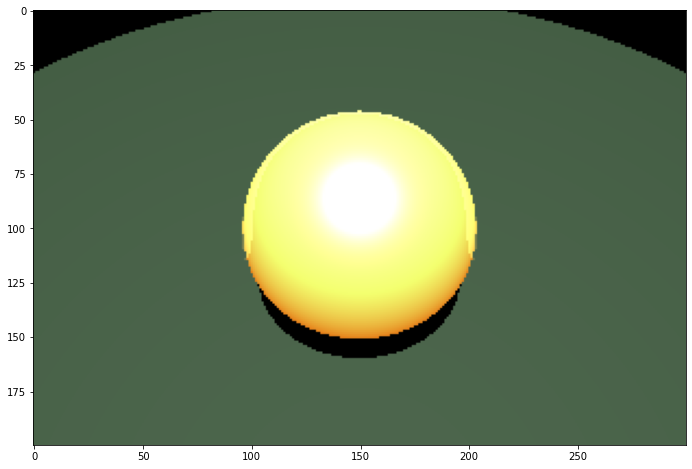

In [7]:
# Test run it

image = run(
    noon_sun,
    objects,
    camera
)

plt.imshow(image)

## Iterate over a day

In [ ]:
gif_outputs(all_images)

Making ./plots/2022-10-12_00h25/


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Making ./plots/2022-10-12_00h08/


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/s4/815zz3k92kl8dnd2dp609xx40000gp/T/ipykernel_22714/4082389159.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pngs = [imageio.imread(fname) for fname in tqdm(filenames)]


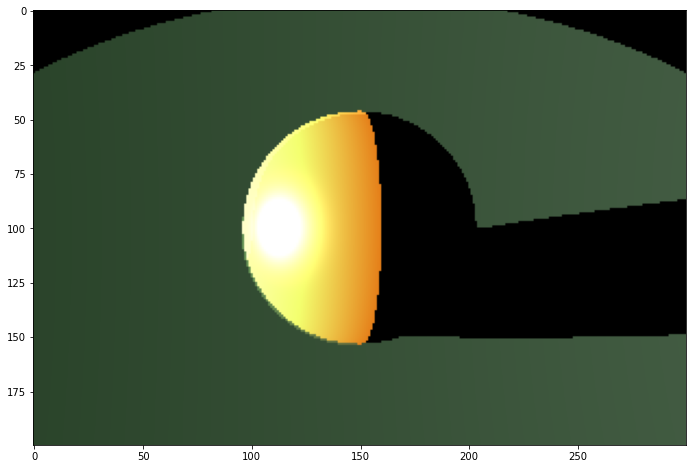

In [8]:
n = 20  # Number of timesteps

all_images = []
for i in range(n):
    # Assuming we're standing on the equator, it just goes in 2D (XZ) arc
    sun_y = 0  # y is north/south. This will factor in if we do non-equatorial stuff
    sun_x = AU_TO_M * np.cos(i*np.pi/n)
    sun_z = AU_TO_M * np.sin(i*np.pi/n)
    sun = {
        'position': np.array([sun_x, sun_y, sun_z]),
        'ambient': np.array([1, 1, 1]),
        'diffuse': np.array([1, 1, 1]),
        'specular': np.array([1, 1, 1])
    }


    # Might want to iterate over sides of a cube to get all incident light.
    # Or just make a really wide camera
    image = run(
        sun,
        objects,
        camera
    )
    all_images.append(image)

gif_outputs(all_images)